# Portfolio Project: Safety Option

**Names:** Deniz Makul, Richard Sha, Mitchel Shen

**Portfolio Investment Strategy:** Safe

**Team Number:** 08

**Due:** 11/25/2022 at 11:59pm ET on Dropbox

**What to submit:** your .ipynb (python code in jupyter notebooks) file as well as a pdf with all the output from your code.  




# The Assignment: 

The goal of this assignment is to create a dynamic portfolio that generates the least amount of returns possible. We will analyze various factors and use the results of our analysis to dynamically build a portfolio that we believe will stay as close as possible to the intial investment price of $500k

In [28]:
from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from threading import Thread
import time

In [29]:
#Getting tickers from csv file
csv_tickers = pd.read_csv('Tickers.csv', header = None)

# The Filtering Process:

The filtering process below will filter out stocks that are not to be utilized according to the assignment instructions. 

The following processes are performed

1. Trading months that have less than 20 trading days are filtered out and are not used for the process in Step 2

2. Stocks that have an average monthly volume of less than 200,000 shares are filtered out for the time interval January 01, 2022 - October 31, 2022 (months that have less than 20 trading days not looked at as mentioned in Step 1)

3. Non US-based stocks are filtered out

4. Delisted stocks are filitered out


After our filtering process, which makes use of threading for faster runtime, we receive a list of the indexes of our ineligible tickers, which we then use to create a dataframe of eligible tickers. 

In [30]:
# Returns a list of of months that have less than 20 trading days

#Setting start date and end date for volume filtering, uses 11-01 to get October as the last month
volume_start_date = '2022-01-01'
volume_end_date = '2022-11-01'

#Function to remove a month from a dataframe for volume analysis if there are less than 20 days
def remove_month(ticker):
    hist = ticker.history(start = volume_start_date, end = volume_end_date)
    
    months_to_remove = []
    #Loops through each month and creates a dataframe for each day containing data for the stock for the month
    for i in range(1,11,1):
        if i <= 9: #appends a 0 if single digit
            i = str(0) + str(i)
        df = hist.filter(like='2022-' + str(i), axis=0)
        
        #Adds to month_to_remove array if there are less than 20 rows (signalling that there were less than 20 trading days
        #for that stock)
        if len(df.index) < 20:
            months_to_remove.append('2022-' + str(i))
    return months_to_remove

In [31]:
#list to store which stocks to remove (based on indicies)
volume_index_drop = []

#Filter function, uses threading to speed up the process
def filter_stocks(ticker, i):
    stock_data = yf.Ticker(ticker)
    stock_hist = stock_data.history(start = volume_start_date, end = volume_end_date, interval = '1mo', Threads = True)
    
    #If no data exists for a particular data, then the stock has been delisted, so we remove that stock
    if stock_hist.empty:
        volume_index_drop.append(i)
        return
    
    stock_volume = stock_hist['Volume']
    stock_volume = stock_volume.dropna()
    #drops the month where there are less than 20 trading days
    stock_volume = stock_volume.drop(remove_month(stock_data))
    
    mean = (stock_volume.mean())
    
    #if the average monthly volume was less than 200000, or if the stock is not in the US market, add the index to the list to 
    #drop
    if mean<200000:
        volume_index_drop.append(i)         
    elif(stock_data.info['market'] != 'us_market'):
        volume_index_drop.append(i)
    
    #volume_index_drop

In [32]:
#Drops the tickers that are delisted or have a average monthly volume from 
# January 1st to October 31st of less that 200,000

# thread_list contains all the threads
thread_list = []

for i in range(len(csv_tickers)):
    ticker = csv_tickers[0][i]
    filter_thread = Thread(target = filter_stocks, args = (ticker,i,))
    thread_list.append(filter_thread)
    #starts the threading
    filter_thread.start()

for i in thread_list:
    i.join()


- AGN: No data found, symbol may be delisted
- CELG: No data found, symbol may be delisted
- PCLN: No data found for this date range, symbol may be delisted
- RTN: No data found, symbol may be delisted
- TWX: No data found for this date range, symbol may be delisted


In [33]:
#Drops invalid tickers based on volume_index_drop
csv_tickers.drop(index = volume_index_drop, inplace = True)
csv_tickers.reset_index(drop = True, inplace = True)
csv_tickers.head()

,0
0,AAPL
1,ABBV
2,ABT
3,ACN
4,AIG


In [34]:
close_all = pd.DataFrame()
#Gets the current date
close_date = datetime.today().strftime('%Y-%m-%d')

#Gets the close daily close price for all valid stocks in the csv file from January to the current date
def stock_history(ticker):
    close_start = '2022-01-01'
    stock_data = yf.Ticker(ticker)
    stock_hist = stock_data.history(start = close_start, end = close_date, interval = '1d')
    stock_close = stock_hist['Close']
    stock_close = stock_close.dropna()
    close_all[ticker] = stock_close

In [35]:
for i in range(0,len(csv_tickers)):
    ticker = csv_tickers[0][i]
    stock_history(ticker)
    
close_all.head()

,AAPL,ABBV,ABT,ACN,AIG,AMZN,AXP,BA,BAC,BIIB,...,SLB,SO,SPG,T,TGT,TXN,UNH,UNP,UPS,USB
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-03,180.959732,130.341797,136.745361,401.729401,56.390324,170.404495,166.056259,207.860001,45.393047,244.139999,...,31.361925,65.578415,153.253540,17.874918,227.143723,185.358871,497.457550,243.742813,206.660675,55.597622
2022-01-04,178.663071,130.091568,133.529327,398.858582,57.972286,167.522003,171.387100,213.630005,47.172203,241.729996,...,32.884541,65.578415,155.815720,18.022526,229.317703,185.553360,486.186798,247.933548,210.329269,57.053822
2022-01-05,173.910660,130.774918,132.929398,391.834412,57.176388,164.356995,169.560791,213.070007,46.376007,239.270004,...,32.884541,65.655388,153.951431,18.423185,224.117737,181.682800,484.988434,248.681198,207.686722,56.752869
2022-01-06,171.007507,130.158920,132.909729,372.912567,58.158974,163.253998,171.114563,211.339996,47.309818,237.300003,...,33.665623,65.578415,155.987808,18.352894,226.556168,181.624435,465.140808,249.369827,209.700073,58.296440
2022-01-07,171.176544,129.822067,133.322800,365.760132,59.681973,162.554001,172.579315,215.500000,48.341927,232.600006,...,34.634560,66.030563,154.180893,18.979885,225.997971,174.505737,454.196899,250.638855,211.171417,59.218700


In [36]:
#Gets the daily percentage change of each stock
close_all_pct = close_all.pct_change() * 100
close_all_pct.head()

,AAPL,ABBV,ABT,ACN,AIG,AMZN,AXP,BA,BAC,BIIB,...,SLB,SO,SPG,T,TGT,TXN,UNH,UNP,UPS,USB
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-04,-1.269156,-0.191979,-2.351841,-0.714615,2.805380,-1.691559,3.210262,2.775909,3.919445,-0.987140,...,4.854981,0.000000,1.671857,0.825782,0.957095,0.104925,-2.265671,1.719327,1.775178,2.619176
2022-01-05,-2.659985,0.525284,-0.449287,-1.761068,-1.372895,-1.889309,-1.065605,-0.262134,-1.687850,-1.017661,...,0.000000,0.117375,-1.196470,2.223104,-2.267582,-2.085955,-0.246482,0.301553,-1.256386,-0.527489
2022-01-06,-1.669336,-0.471036,-0.014796,-4.829041,1.718517,-0.671098,0.916351,-0.811945,2.013565,-0.823338,...,2.375226,-0.117238,1.322740,-0.381538,1.088013,-0.032125,-4.092392,0.276912,0.969418,2.719812
2022-01-07,0.098848,-0.258801,0.310790,-1.917993,2.618682,-0.428778,0.856007,1.968394,2.181594,-1.980614,...,2.878120,0.689478,-1.158370,3.416307,-0.246384,-3.919461,-2.352816,0.508894,0.701642,1.582018


In [37]:
#Gets the expected return as a percentage for each stock over the period from January 1st, 2022 to October 31st, 2022
expected_return = close_all_pct.mean()
expected_return.head()

AAPL   -0.054789
ABBV    0.100161
ABT    -0.098412
ACN    -0.116549
AIG     0.057415
dtype: float64

In [38]:
#Gets the absolute differnce of the expected return from 0
expected_return_from_0 = abs(0 - expected_return)
expected_return_from_0

#Sorts the values in expected_return_from_0 from least to greatest
expected_return_sorted = sorted(expected_return_from_0.items(), key=lambda x:x[1])

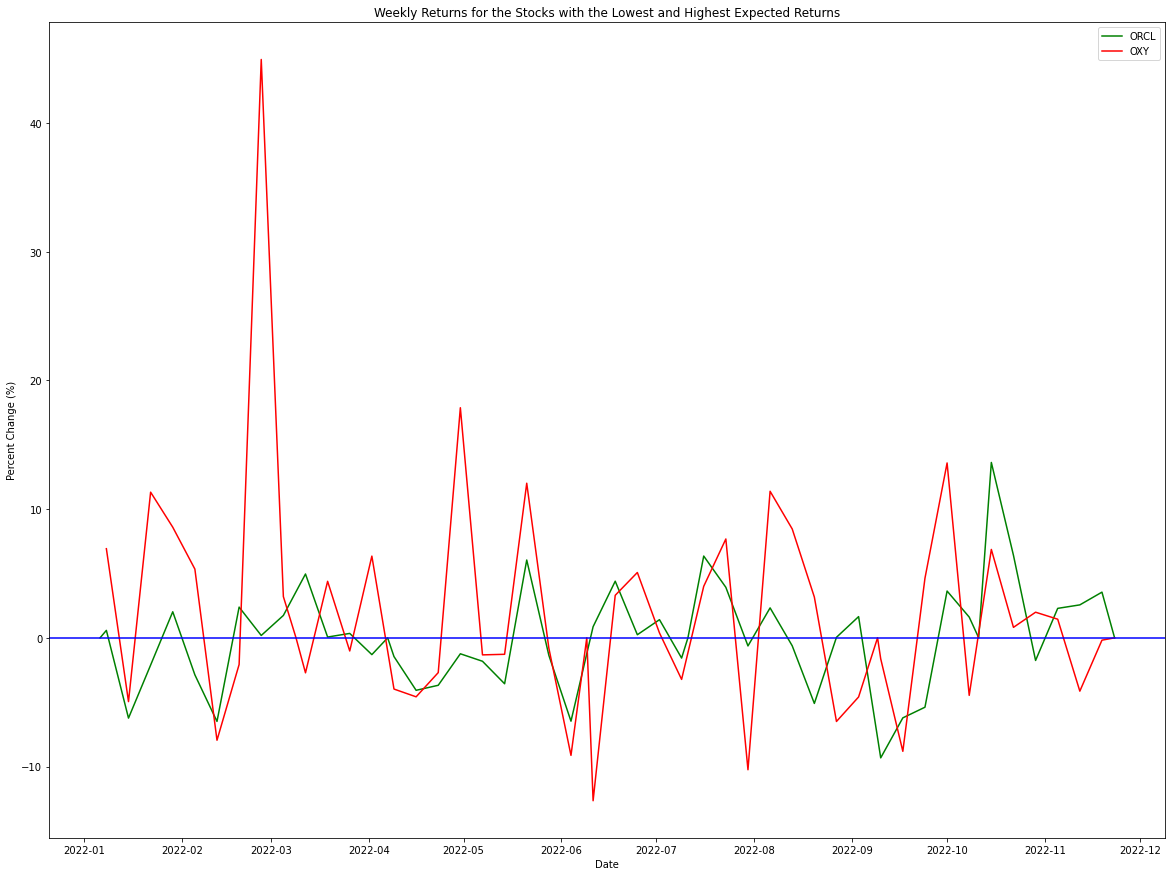

In [39]:
start_date = '2022-01-01'

lowest_expected = expected_return_sorted[0][0]
highest_expected = expected_return_sorted[-1][0]

lowest = yf.Ticker(lowest_expected)
lowest_hist = lowest.history(start=start_date, end=close_date, interval="1wk")
lowest_df = pd.DataFrame(lowest_hist.Close)
lowest_df_pct = lowest_df.pct_change()*100

highest = yf.Ticker(highest_expected)
highest_hist = highest.history(start=start_date, end=close_date, interval="1wk")
highest_df = pd.DataFrame(highest_hist.Close)
highest_df_pct = highest_df.pct_change()*100

plt.figure(figsize=(20,15))

plt.plot(lowest_df_pct.index, lowest_df_pct['Close'], color = 'g', label=lowest_expected)
plt.plot(highest_df_pct.index, highest_df_pct['Close'], color = 'r', label=highest_expected)
plt.axhline(y=0, color='b', linestyle='-')

plt.legend(loc='best')

plt.title('Weekly Returns for the Stocks with the Lowest and Highest Expected Returns')
plt.xlabel('Date')
plt.ylabel('Percent Change (%)')

plt.show()

In [40]:
#Gets the standard deviation of each stock from January 1st to October 31st, 2022
std_lst = close_all_pct.std()
std_lst = sorted(std_lst.items(), key=lambda x:x[1])

In the code block above, we calculated the standard deviation for each ticker and appended into a list called ‘std_lst’. After that, we sorted the list so that the ticker by ascending order so that the lowest standard deviation would be at index 0, the start of the list. The reason we sorted the standard deviation by ascending order was so that the stock at first place would get the most points in our ranking system to decide the weighting of the stocks.

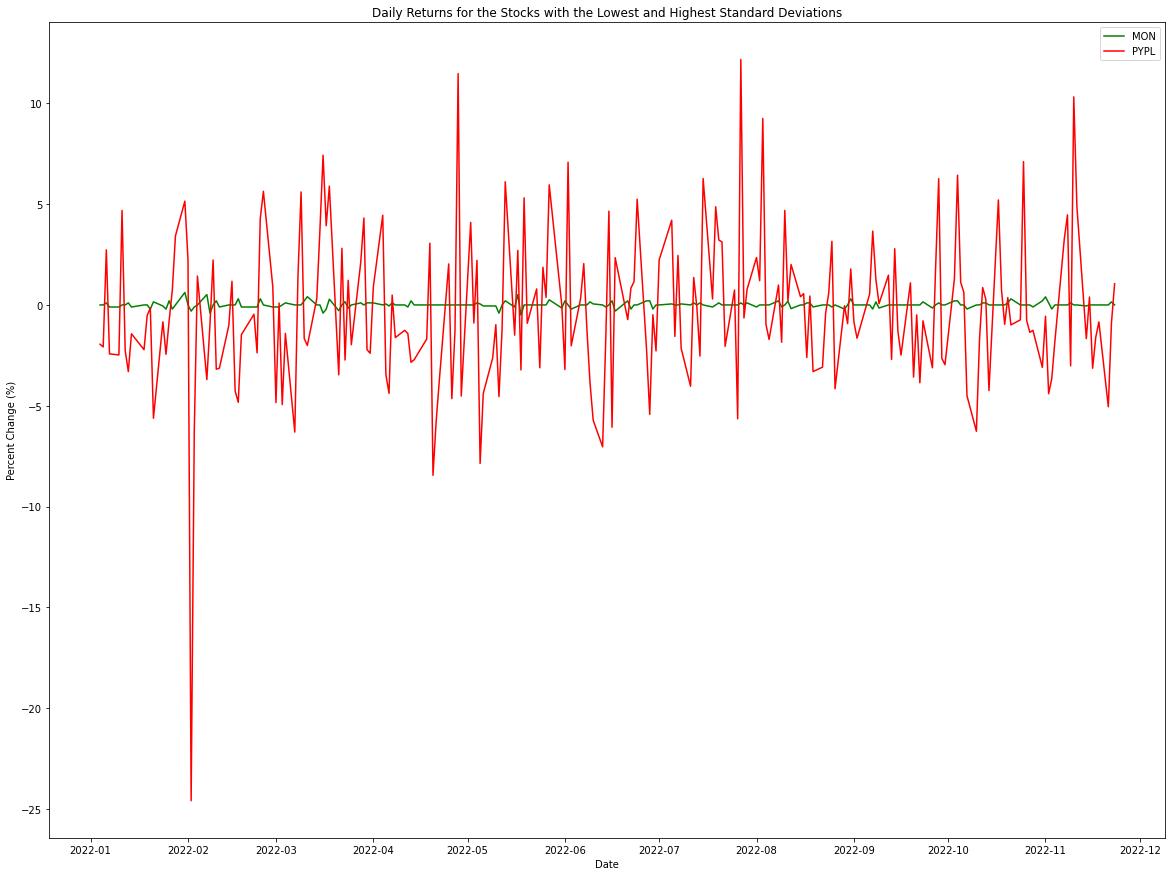

In [41]:
lowest_std = std_lst[0][0]
highest_std = std_lst[-1][0]

plt.figure(figsize=(20,15))

plt.plot(close_all_pct.index, close_all_pct[lowest_std], color = 'g', label=lowest_std)
plt.plot(close_all_pct.index, close_all_pct[highest_std], color = 'r', label=highest_std)

plt.legend(loc='best')

plt.title('Daily Returns for the Stocks with the Lowest and Highest Standard Deviations')
plt.xlabel('Date')
plt.ylabel('Percent Change (%)')

plt.show()

As you can see from the graph above, the ticker with the greater standard deviation fluctuates significantly more than the ticker that has a lower standard deviation. This is because in portfolios, standard deviation is a measure of risk and so a stock with a higher standard deviation will be more risky than a stock with a lower standard deviation. By assigning more points and thus weighting the stock with the lower standard deviation higher, we are ensuring that our portfolio will be as safe as possible by mitigating and reducing the number of significant fluctuations that occur in a given trading day.

In [42]:
correlation_pct_stocks = pd.DataFrame()
index = []

#Creates a DataFrame that stores correlation between any two given stocks given that the ticker is acceptable
for i in range(len(close_all_pct.columns)):
    
    #Tracks the correlation of one stock to every stock in the portfolio
    correlation_temp = {}
    
    for j in range(len(close_all_pct.columns)):
        #correlation_df: Temporary dataframe so that .corr() function can be applied to the dataframe
        correlation_df = pd.DataFrame({
            csv_tickers[0][i]: close_all_pct[csv_tickers[0][i]]
        })
        
        correlation_df[csv_tickers[0][j]] = close_all_pct[csv_tickers[0][j]]
        correlation = correlation_df.corr()[csv_tickers[0][i]][csv_tickers[0][j]]
        
        correlation_temp[csv_tickers[0][j]] = correlation
        
    correlation_pct_stocks[csv_tickers[0][i]] = list(correlation_temp.values())
    index.append(csv_tickers[0][i])

#Sets resets index values for better understanding of data
correlation_pct_stocks.index = index
correlation_pct_stocks.head()

,AAPL,ABBV,ABT,ACN,AIG,AMZN,AXP,BA,BAC,BIIB,...,SLB,SO,SPG,T,TGT,TXN,UNH,UNP,UPS,USB
AAPL,1.000000,0.222582,0.619350,0.798654,0.554765,0.691117,0.653674,0.537584,0.570125,0.297340,...,0.206058,0.394055,0.596477,0.396792,0.521212,0.734526,0.481119,0.482695,0.563516,0.484424
ABBV,0.222582,1.000000,0.457486,0.328319,0.313108,0.208196,0.280863,0.115592,0.302679,0.237923,...,0.178286,0.377696,0.275196,0.271573,0.266804,0.254633,0.498843,0.251952,0.234951,0.392162
ABT,0.619350,0.457486,1.000000,0.696368,0.536109,0.504969,0.598784,0.430043,0.580336,0.325455,...,0.117437,0.459859,0.535696,0.381756,0.406746,0.545281,0.558016,0.497194,0.491663,0.566946
ACN,0.798654,0.328319,0.696368,1.000000,0.591425,0.694861,0.668331,0.506780,0.592195,0.374402,...,0.197518,0.416223,0.633159,0.375828,0.525819,0.738584,0.518510,0.555304,0.595139,0.539502
AIG,0.554765,0.313108,0.536109,0.591425,1.000000,0.458671,0.730973,0.542381,0.761023,0.247939,...,0.389726,0.292853,0.605094,0.377247,0.337922,0.494066,0.385524,0.503319,0.519038,0.728714


# Correlation

For correlation, we calculated the correlation of a stock to each stock and put it in a dataframe to be analyzed. In Finance, correlation is a metric used to determine how the stock movements of two stocks, or portfolios of stocks, compare. The formula for correlation is given by: 

\begin{align*}
COR(X,Y)=\frac{COV(X,Y)}{\sigma_X \times \sigma_Y}
\end{align*}

where the covariance of X and Y is divided by the standard deviation of X is multipled by the standard deviation of Y

A correlation of 1 means that the two stocks being compared move perfectly together, both up and down. A correlation of -1 means that the two stocks being analyzed move in opposite directions all the time in perfect fashion. In the real world, both cases of correlation of 1 and -1 for two particular stocks is highly unlikely to happen, as even the smallest deviation would cause the correlation to not be 1 or -1. Finally, a correlation of 0 suggests that there is no pattern or correlation between the two stocks at all. Like the case of a correlation of 1 and -1, a correlation of 0 between two stocks is highly unlikely as even two stocks with the most random stock movements will always have some relationship, albeit small in magnitude.


In [43]:
#Tracks the average correlation of a stock to the rest of the stocks
correlation_pct_mean = pd.DataFrame()
correlation_pct_mean = correlation_pct_stocks.sum()

#Subtracts 1 to account for the case in the dataframes where a stock is compared to itself for correlation
#the correlation would be 1 in this case (such as AAPL's correlation with AAPL)
correlation_pct_mean = correlation_pct_mean - 1

#One less stock (len(correlation_pct_stocks) - 1)since we don't take into account the stock itself in the 
#correlation calculations
correlation_pct_mean = correlation_pct_mean/(len(correlation_pct_stocks) - 1)

correlation_pct_mean.head()

AAPL    0.500083
ABBV    0.297330
ABT     0.474111
ACN     0.521697
AIG     0.471928
dtype: float64

For our portfolio, we want the safest portfolio, where there is minimal movement to the value of the portfolio at all times. From our diversification discussion, we wanted to pick as many stocks as possible to put in our portfolio, which complicates things since correlation is typically a measure of the relationship between only two stocks. Thus, we decided to take the average correlation of a stock to the stocks in the rest of the ticker list. Since we are going for the safest portfolio, one may assume that stocks that have high negative average correlation values will pair well with stocks that have high positive average correlation values to attain as little movement between the stocks as possible. However, there may be an uneven distribution of stocks that have high positive average correlation values and high negative average correlation values. In the case of the example tickers, there were NO stocks that had an average correlation value below 0. In addition, it may be hard to find a perfect pair of stocks with high negative average correlation and high positive average correlation values. As a result, we need another more robust method of considering stocks based on the correlation with the rest of the tickers.

From the portfolio theory that we learned in class, stocks that have little correlation with each other (near 0) mitigates risk and increases the safety of stock since when a stock goes down, the other stock may not have decreased, and thus will help mitigate some of the losses attained by the first stock that decreased in value. On the contrary, if the value of a stock went up, another stock that had a correlation near 0 might not have, and thus will reduce the profits attained by both stocks, hence creating a portfolio that has minimal movement in value. Thus, we settled on weigthing/favouring stocks that had average correlation values near zero.

Hence, the code block below sorts the average correlation values for each stock from the stocks with least difference between average correlation values and 0 to the stocks with the stocks with the highest difference between average correlation values and 0.


In [44]:
#Gets the absolute value of the correlation from 0 (least correlation) and sorts it from least to greatest
correlation_from_0 = abs(0 - correlation_pct_mean)
correlation_from_0 = sorted(correlation_from_0.items(), key=lambda x:x[1])

# The Point-Weighting System

The following sections applies our above analyses into creating a dynamic portfolio.

### The Point System

We developed a point-weighting system to determine how much of each stock we would like to purchase for the simulation. We begin by applying our point system which will award the most points to our safest stock. The results from our analyses of expected return, standard deviation, and correlation are used to create a dataframe. This dataframe contains those 3 categories sorted in increasing order, accompanied by an index in decreasing order ranging from the total number of stocks to 1.

<b>The index represents the number of points that will be awarded to each stock for each category. 

Say, for example, in a field of 30 stocks, AT&T (NYSE: T) places 1st in expected returns, 3rd in standard deviation, and 29th in correlation. Our index would range from 30 in the first row down to 1 for the bottom row. Our point-based system would then award 30 points for expected returns, 28 points for standard deviation, and 2 points for correlation, for a total of 60 points. This means that each category is essentially weighted equally at ⅓.

The result of this application can be seen on the following dataframe, where the total points for each stock has been tallied up. The stock at the top of the list is seen as our "safest" stock and will receive the most weighting, while the stock at the bottom is seen as our riskiest, and probably won't even be included in our portfolio entirely. 
    
The resulting dataframe is then given a cutoff so that only the top 25 stocks remain in our dataframe, the maximum allowed for this assignment. In the rare case that we happen to receive a stock list with fewer than 25 stocks, than all will be included in our portfolio for the sake of diversification. 
 
### The Weighting System
    
After the points have been calculated for each stock, we apply our weighting system. The weighting system awards a base weighting of [100/(2 x # of Stocks)] to each stock, since each stock must make up a minimum of 2% of the portfolio according to assignment instructions. The rest of the weighting is calculated by dividing the points belonging to the stock by the total number of points, and them multiplying the resulting value by (100 - base weight). This weighting system makes it so that there isn't much variation between the top stock and the bottom stock of our portfolio. The variation will be within a few percetage points of each other.
    
### The Importance of Diversification
    
Our program aims to make use 25 stocks if possible, since that is the maximum allowed number of stocks in our portfolio. The more stocks there are, the greater the chance of inter-industry variation in our portfolio, since there is a greater chance that a stock from a different industry will be added to our portfolio. This brings up the importance of diversification. By allocating investments across various stocks and industries, we are able to minimize risk so that if something happens to one stock, this change will be counterbalanced by the other stocks in our portfolio. This will help reduce the volatility experienced by the portfolio over the week-long simulation to help acheive minimal returns on investments, as desired by the assignment.


In [45]:
#Creates points system
points_system = pd.DataFrame()
expected_lst = []
std_deviation_lst = []
correlation_lst = []

#Appends each stock and their rankings in the expected_lst, std_deviation and correlation_lst dataframes
for i in expected_return_sorted:
    expected_lst.append(i[0])
    
for i in std_lst:
    std_deviation_lst.append(i[0])

for i in correlation_from_0:
    correlation_lst.append(i[0])

points_system['Expected Returns'] = expected_lst
points_system['Standard Deviation'] = std_deviation_lst
points_system['Correlation'] = correlation_lst
points_system.index += 1 

#Inverses the index for the points system
points_system = points_system.set_index([points_system.index[::-1]])

points_system.head()

,Expected Returns,Standard Deviation,Correlation
55,ORCL,MON,MON
54,COST,BMY,LMT
53,NEE,PEP,OXY
52,TXN,KO,SLB
51,CVS,MRK,BMY


In [46]:
#Score dataframe keeps track of the points accumulated by a stock in all three categories (expected returns, standard deviation,
#correlation)
score = pd.DataFrame()
    
score['Tickers'] = expected_lst
score['Points'] = None

for i in range(len(score)):
    score['Points'][i] = (int(points_system[points_system['Expected Returns'] == expected_lst[i]].index.values)) + (int(points_system[points_system['Standard Deviation'] == expected_lst[i]].index.values)) + (int(points_system[points_system['Correlation'] == expected_lst[i]].index.values)) 

score = score.sort_values("Points")
score = score[::-1]
score = score.reset_index(drop=True)
score.index += 1 

score.head()

,Tickers,Points
1,MON,157
2,MO,139
3,SO,136
4,CL,134
5,PG,130


In [47]:
number_of_stocks = 25

#Creates a dataframe of the top stocks to pick (25 stocks if there are 25 or more stocks in the list, the same dataframe as 
#score if there are less)
score_dropped = score.copy()

#Accounts for the case where there are less than the number of stocks we want (25) valid tickers in the list; only when 
#there are more than 25 valid tickers would we take the first 25 tickers from the score dataframe
if (len(score) > number_of_stocks):
    score_dropped.drop(labels = range(number_of_stocks + 1, len(score) + 1), inplace = True)
score_dropped.head()

,Tickers,Points
1,MON,157
2,MO,139
3,SO,136
4,CL,134
5,PG,130


In [48]:
#Minimum weighting possible for any given stock so that there is no case where the weighting of one stock drops below the 
#minimum weighting requirement for a given stock
min_weighting = 100/(2*number_of_stocks)
base_weighting_total = min_weighting * number_of_stocks

#Gets the finalized weightings of each stock
score_dropped['Base Weighting'] = min_weighting
weighting_sum = score_dropped['Points'].sum()

score_dropped['Points-based Weighting'] = (score_dropped['Points']/weighting_sum) * (100 - base_weighting_total)
score_dropped['Total Weighting'] = score_dropped['Base Weighting'] + score_dropped['Points-based Weighting']
score_dropped.head()

,Tickers,Points,Base Weighting,Points-based Weighting,Total Weighting
1,MON,157,2.0,2.745715,4.745715
2,MO,139,2.0,2.43092,4.43092
3,SO,136,2.0,2.378454,4.378454
4,CL,134,2.0,2.343477,4.343477
5,PG,130,2.0,2.273522,4.273522


In [49]:
tickers_list = score_dropped['Tickers']
#Gets the closing price for last five days. Five days incase the program is run on the weekend and Friday is a holiday
price_last_five_days = pd.DataFrame()
Portfolio_Final = pd.DataFrame()
date_difference = 5

#initialize start_date for getting close dates from yfinance
start_date = datetime.today() - timedelta(days=date_difference)

#Getting price info for the last date (in this case 2022-11-25)
for x in tickers_list:
    stock_info = yf.Ticker(x)
    stock_hist = stock_info.history(start = start_date, end = close_date)
    
    price_last_five_days[x] = stock_hist['Close']
    
price_last_five_days = price_last_five_days.transpose()
#Gets the last column from price_last_five_days
Portfolio_Final = price_last_five_days.iloc[:,-1]
Portfolio_Final = Portfolio_Final.reset_index()
Portfolio_Final.index += 1

Portfolio_Final.head()

,index,2022-11-23 00:00:00
1,MON,10.010000
2,MO,45.020000
3,SO,66.360001
4,CL,76.930000
5,PG,146.449997


In [50]:
total_amount_to_spend = 500000
#To reset column names
column_names = ['Ticker', 'Price']
Portfolio_Final.columns = column_names

#Getting the rest of the columns for the Portfolio_Final dataframe
Portfolio_Final['Shares'] = (total_amount_to_spend*(score_dropped['Total Weighting']/100))/Portfolio_Final['Price']
Portfolio_Final['Value'] = Portfolio_Final['Shares'] * Portfolio_Final['Price']
Portfolio_Final['Weight'] = score_dropped['Total Weighting']
Portfolio_Final


,Ticker,Price,Shares,Value,Weight
1,MON,10.010000,2370.487101,23728.576425,4.745715
2,MO,45.020000,492.105715,22154.59951,4.43092
3,SO,66.360001,329.901595,21892.270024,4.378454
4,CL,76.930000,282.30058,21717.383701,4.343477
5,PG,146.449997,145.9038,21367.611053,4.273522
6,PM,98.110001,215.118555,21105.281567,4.221056
7,CVS,100.059998,209.17845,20930.395243,4.186079
8,PFE,48.849998,424.882489,20755.508919,4.151102
9,NEE,84.919998,242.353074,20580.622595,4.116125
10,BMY,79.139999,256.738606,20318.293109,4.063659


In [51]:
#Generating Stocks_Final portfolio
Stocks_Final = pd.DataFrame()

Stocks_Final['Ticker'] = Portfolio_Final['Ticker'] 
Stocks_Final['Shares'] = Portfolio_Final['Shares']

Stocks_Final

,Ticker,Shares
1,MON,2370.487101
2,MO,492.105715
3,SO,329.901595
4,CL,282.30058
5,PG,145.9038
6,PM,215.118555
7,CVS,209.17845
8,PFE,424.882489
9,NEE,242.353074
10,BMY,256.738606


# Final Observations

Note that from the final weightings, there is no stock that is more heavily weighted than other stocks. Thus, the portfolio is more evenly distributed, although not perfectly even distributed. As these results are based on past results, statistical anomalies may occur in the future, and as a result, any one of these stocks may have a sudden volatile movement regardless of past performance. Since the portfolio is pretty evenly distributed, the volatile movement of one individual stock will not greatly affect the performance of the portfolio. 


In [52]:
#Writing to csv file
Stocks_Final.to_csv("Stocks_Group_08.csv")

## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

Deniz Makul, Richard Sha, Mitchel Shen.